In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

In [2]:
## Load and Clean Data
def load_and_clean_data(filepath):
    # Load the dataset
    tracks = pd.read_csv(filepath)

    # Drop unnamed column if it exists
    if 'Unnamed: 0' in tracks.columns:
        tracks = tracks.drop('Unnamed: 0', axis=1)

    # Fill missing values for numerical columns
    tracks = tracks.fillna(tracks.mean(numeric_only=True))

    # Clean genre and artist columns
    if 'genres' in tracks.columns:
        tracks['genres'] = tracks['genres'].apply(lambda x: eval(x) if isinstance(x, str) else [])
    if 'track_artists' in tracks.columns:
        tracks['track_artists'] = tracks['track_artists'].apply(lambda x: eval(x) if isinstance(x, str) else [])

    return tracks

In [3]:
## Add Features
def add_features(tracks):
    # Add dynamic threshold for emerging artists
    popularity_threshold = tracks['artist_popularity'].quantile(0.4)
    print('Popularity Threshold set to ', popularity_threshold)
    emerging_artists_tracks = tracks[tracks['artist_popularity'] < popularity_threshold]

    # Extract recency of album release
    tracks['album_release_date'] = pd.to_datetime(
        tracks['album_release_date'], errors='coerce', format='mixed'
    )
    tracks['album_release_year'] = tracks['album_release_date'].dt.year
    tracks['years_since_release'] = 2024 - tracks['album_release_year']

    return emerging_artists_tracks

In [4]:
## Build KNN Model
def build_knn_model(tracks, audio_features, n_neighbors=5):
    scaler = StandardScaler()
    tracks.loc[:, audio_features] = scaler.fit_transform(tracks[audio_features])

    # Initialize and fit the KNN model
    knn = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine')
    knn.fit(tracks[audio_features])

    return knn

In [5]:
## Get Recommendations
def get_recommendations(song_name, tracks, knn_model, audio_features):
    def clean_song_name(name):
        if not isinstance(name, str):  # Check if name is a string before processing
            return ''  # Return empty string or some placeholder for non-string values
        name = name.strip().lower()  # Convert to lowercase and strip spaces
        name = re.sub(r'[^\w\s]', '', name)  # Remove punctuation (keeping only alphanumeric and spaces)
        return name

    # Clean the input song name
    cleaned_song_name = clean_song_name(song_name)

    # Find all rows with the matching song name
    matching_songs = tracks[tracks['name'].apply(lambda x: clean_song_name(x) == cleaned_song_name)]

    if matching_songs.empty:
        similar_songs = tracks['name'].apply(lambda x: cleaned_song_name in clean_song_name(x))
        if similar_songs.any():
            suggestions = tracks[similar_songs]['name'].head(5).tolist()
            raise ValueError(f"No exact match for '{song_name}'. Did you mean: {', '.join(suggestions)}?")
        else:
            raise ValueError(f"No songs found with the name '{song_name}'.")

    recommendations = []
    for index in matching_songs.index:
        # Extract the row as a DataFrame with feature names
        input_features = tracks.loc[index, audio_features].to_frame().T
        distances, indices = knn_model.kneighbors(input_features)

        # Ensure that the indices are within the valid range
        for idx, distance in zip(indices[0], distances[0]):
            if 0 <= idx < len(tracks):  # Check if the index is valid
                if idx != index:  # Exclude the query song itself
                    recommendations.append({
                        'name': tracks.iloc[idx]['name'],
                        'track_artists': tuple(tracks.iloc[idx]['track_artists']),  # Convert to tuple
                        'similarity_score': round(1 / (1 + distance), 2)  # Add similarity score
                    })

    # Convert track_artists to tuple to ensure hashability
    recommendations_df = pd.DataFrame(recommendations)
    recommendations_df['track_artists'] = recommendations_df['track_artists'].apply(tuple)

    return recommendations_df.drop_duplicates()

In [6]:
## Visualize Data
def visualize_audio_features(tracks, audio_features):

    # Correlation heatmap of audio features
    plt.figure(figsize=(12, 8))
    sns.heatmap(tracks[audio_features].corr(), annot=True, cmap='coolwarm')
    plt.title('Correlation Between Audio Features')
    plt.show()

In [7]:
def visualize_popularity_vs_audio_features(tracks, audio_features):
    plt.figure(figsize=(16, 12))
    for i, feature in enumerate(audio_features):
        plt.subplot(3, 3, i + 1)
        sns.scatterplot(x=tracks[feature], y=tracks['artist_popularity'], alpha=0.6, color='purple')
        plt.title(f'Artist Popularity vs {feature}')
        plt.xlabel(feature)
        plt.ylabel('Artist Popularity')
    plt.tight_layout()
    plt.show()

In [8]:
def visualize_recommendations(recommendations, tracks):
    # Convert track_artists in recommendations to tuples for hashability
    recommendations['track_artists'] = recommendations['track_artists'].apply(tuple)

    # Extract artists and their popularity from the original tracks DataFrame
    recommended_artists = [artist for artists in recommendations['track_artists'] for artist in artists]
    artist_popularity = tracks[tracks['track_artists'].apply(lambda x: any(artist in x for artist in recommended_artists))]

    # Create a copy of the filtered DataFrame before modifying it
    artist_popularity = artist_popularity.copy()
    artist_popularity['track_artists'] = artist_popularity['track_artists'].apply(tuple)

    # Group by track_artists and calculate mean popularity
    artist_popularity = artist_popularity.groupby('track_artists')['artist_popularity'].mean()

    # Plot artist popularity
    artist_popularity.sort_values().plot(kind='barh', color='teal', figsize=(10, 6))
    plt.title('Popularity of Recommended Artists')
    plt.xlabel('Artist Popularity')
    plt.ylabel('Artists')
    plt.show()

Popularity Threshold set to  38.0


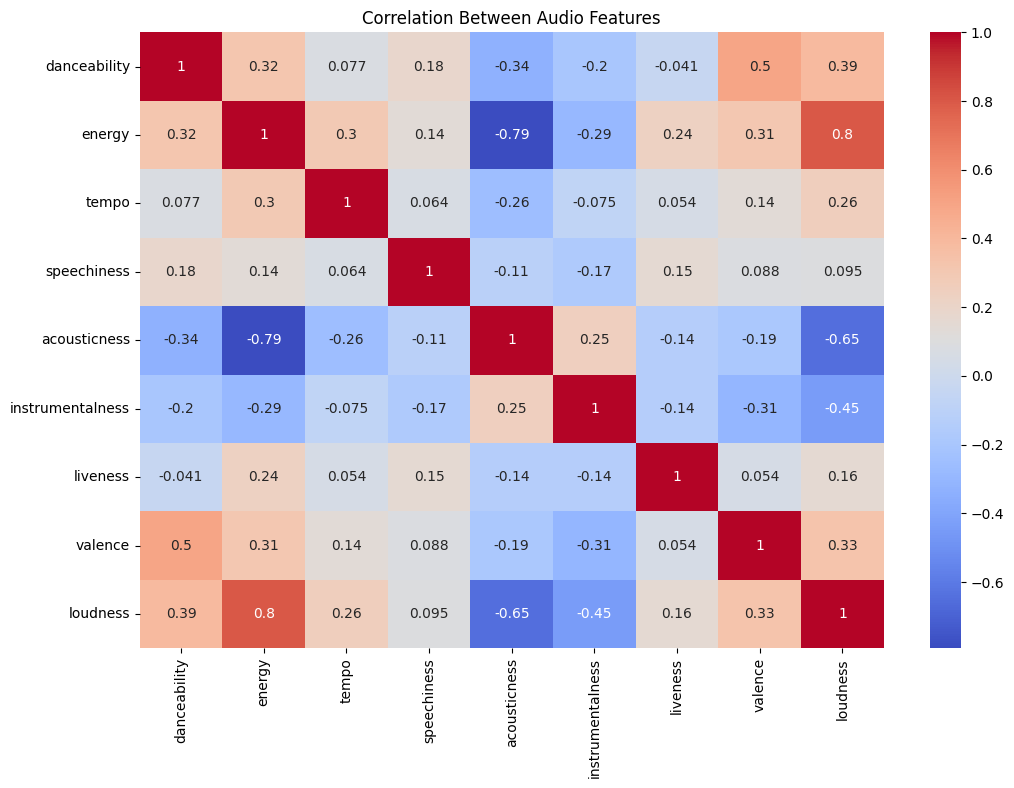

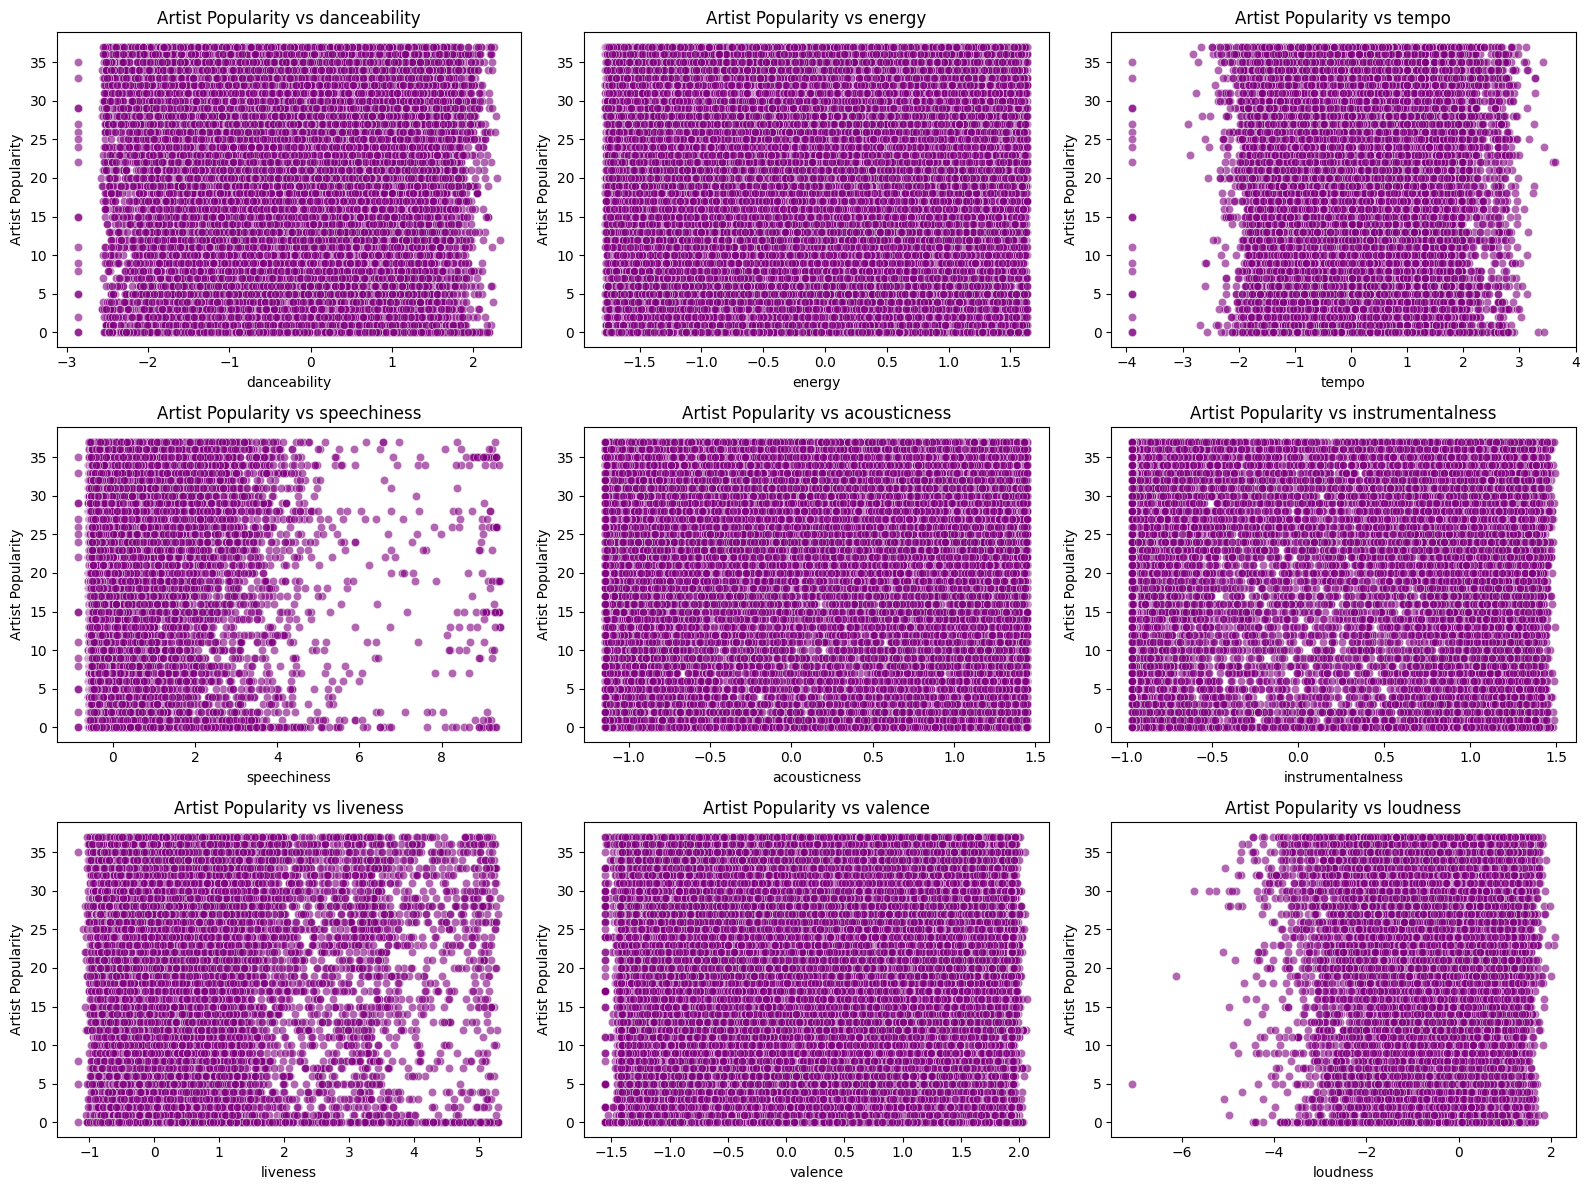

In [9]:
## Main Program
# Load and preprocess the data
filepath = 'final_tracks.csv'
tracks = load_and_clean_data(filepath)
emerging_artists_tracks = add_features(tracks)

# Audio features for the KNN model
audio_features = ['danceability', 'energy', 'tempo', 'speechiness', 
                  'acousticness', 'instrumentalness', 'liveness', 
                  'valence', 'loudness']
knn_model = build_knn_model(emerging_artists_tracks, audio_features)

# Visualize the audio features
visualize_audio_features(emerging_artists_tracks, audio_features)

# Artist Popularity vs. Audio Features
visualize_popularity_vs_audio_features(emerging_artists_tracks, audio_features)


Recommended Songs:
                                     name               track_artists  \
0                           Quiet Moments      (Lonnie Liston Smith,)   
1                         Ship to America                (Michael E,)   
2                  Youth cures everything                   (MAIOLE,)   
3                                   Storm       (Scott Lloyd Shelly,)   
4  Have Yourself a Merry Little Christmas  (Jazz At The Movies Band,)   

   similarity_score  
0              1.00  
1              0.98  
2              0.97  
3              0.95  
4              0.95  


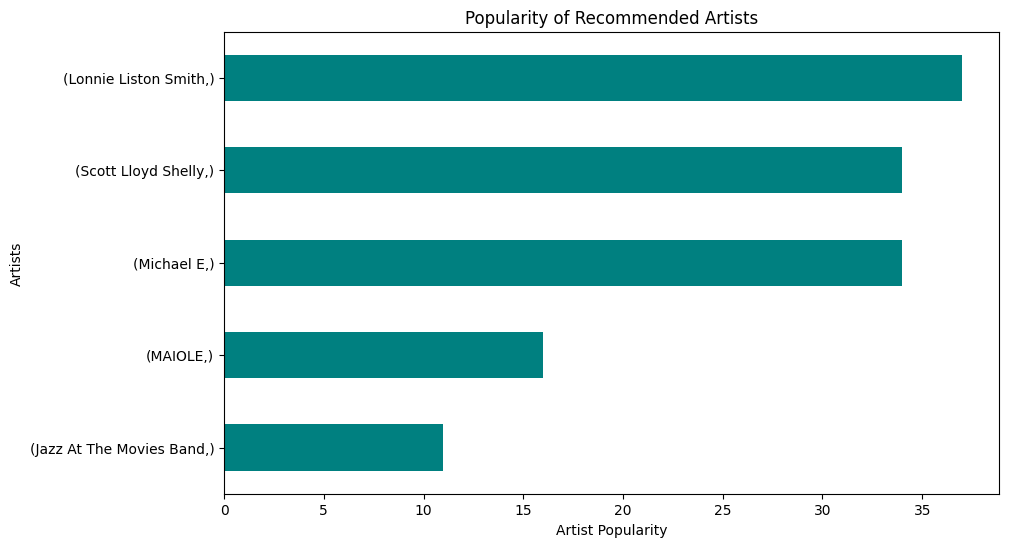

In [10]:
# Test recommendations
try:
    song_name_input = 'Quiet Moments'
    recommendations = get_recommendations(song_name_input, emerging_artists_tracks, knn_model, audio_features)
    print("Recommended Songs:")
    print(recommendations)
except ValueError as e:
    print(e)

# Visualize Recommendations
visualize_recommendations(recommendations, emerging_artists_tracks)

In [11]:
def weighted_content_based_recommendation(song_name, tracks, metadata_features, audio_features, feature_weights):
    """
    Modified content-based recommendation function with weighted feature similarity.
    """
    # Combine metadata and audio features for the full set
    required_columns = metadata_features + audio_features
    missing_columns = [col for col in required_columns if col not in tracks.columns]
    
    if missing_columns:
        print(f"Missing columns: {missing_columns}")
        return None

    # Clean song name for matching
    def clean_song_name(name):
        return str(name).strip().lower()

    cleaned_song_name = clean_song_name(song_name)
    matching_song = tracks[tracks['name'].apply(clean_song_name) == cleaned_song_name]

    if matching_song.empty:
        raise ValueError(f"No song found with name '{song_name}'.")

    # Extract the target features (flattening to 1D array and ensuring numeric values)
    target_features = matching_song.iloc[0][audio_features].values.astype(np.float64)

    # Multiply each feature by its weight
    weighted_target_features = np.array([target_features[i] * feature_weights.get(audio_features[i], 1) for i in range(len(audio_features))])

    # Ensure all features are numeric and handle NaN values by filling them with zeros
    all_features = tracks[audio_features].fillna(0).values.astype(np.float64)

    # Multiply each feature in all tracks by its weight
    weighted_all_features = np.array([
        [all_features[i][j] * feature_weights.get(audio_features[j], 1) for j in range(len(audio_features))]
        for i in range(len(all_features))
    ])

    # Compute cosine similarity
    similarity_scores = cosine_similarity([weighted_target_features], weighted_all_features)

    # Add similarity scores to the tracks DataFrame
    tracks['similarity_score'] = similarity_scores[0]
    recommendations = tracks.sort_values(by='similarity_score', ascending=False).head(5)
    return recommendations[['name', 'track_artists', 'similarity_score']]

In [12]:
# Metadata and audio features
metadata_features = ['genres', 'album_release_year']
audio_features = ['danceability', 'energy', 'tempo', 'speechiness', 'acousticness',
                  'instrumentalness', 'liveness', 'valence', 'loudness']

In [13]:
# Define the weights for each feature
feature_weights = {
    'danceability': 2,
    'energy': 2,
    'tempo': 1,
    'speechiness': 1,
    'acousticness': 0.5,
    'instrumentalness': 0.5,
    'liveness': 1,
    'valence': 1,
    'loudness': 1
}

# Test with a known song name from the dataset
test_song_name = "Quiet Moments"
recommendations = weighted_content_based_recommendation(test_song_name, tracks, metadata_features, audio_features, feature_weights)
print("Recommendations for 'Quiet Moments':\n", recommendations)

Recommendations for 'Quiet Moments':
                                        name          track_artists  \
23                            Quiet Moments  [Lonnie Liston Smith]   
32007                            Aen Seidhe    [Mikolai Stroinski]   
79416     Fly Me To The Moon - Instrumental      [Per Goldschmidt]   
61667  FFVII REMAKE: 作戦決行 (A New Operation)        [Nobuo Uematsu]   
22776                              Serenity       [Luis Hermandez]   

       similarity_score  
23             1.000000  
32007          0.999998  
79416          0.999998  
61667          0.999998  
22776          0.999997  


In [14]:
def latent_feature_based_recommendation(song_name, tracks, metadata_features, audio_features, n_components=5):
    """
    Latent feature-based recommendation using PCA for dimensionality reduction.
    """
    required_columns = metadata_features + audio_features
    missing_columns = [col for col in required_columns if col not in tracks.columns]
    
    if missing_columns:
        print(f"Missing columns: {missing_columns}")
        return None

    # Clean song name for matching
    def clean_song_name(name):
        return str(name).strip().lower()

    cleaned_song_name = clean_song_name(song_name)
    matching_song = tracks[tracks['name'].apply(clean_song_name) == cleaned_song_name]

    if matching_song.empty:
        raise ValueError(f"No song found with name '{song_name}'.")

    # Ensure the audio features are numeric and handle NaN values by filling them with zeros
    all_features = tracks[audio_features].fillna(0).values.astype(np.float64)

    # Apply PCA to reduce the dimensionality of the audio features
    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(all_features)

    # Extract the target song's features and project it into the reduced feature space
    target_song_index = matching_song.index[0]
    target_song_features = all_features[target_song_index].reshape(1, -1)
    reduced_target_song = pca.transform(target_song_features)

    # Compute similarity between the target song and all other songs in the reduced space
    similarity_scores = cosine_similarity(reduced_target_song, reduced_features)

    # Add similarity scores to the tracks DataFrame
    tracks['similarity_score'] = similarity_scores[0]
    recommendations = tracks.sort_values(by='similarity_score', ascending=False).head(5)
    
    return recommendations[['name', 'track_artists', 'similarity_score']]


In [15]:
# Define the number of latent features (components) to retain
n_components = 5

# Test with a known song name from the dataset
test_song_name = "Quiet Moments"
recommendations = latent_feature_based_recommendation(test_song_name, tracks, metadata_features, audio_features, n_components)

print("Latent Feature-Based Recommendations for 'Quiet Moments':\n", recommendations)

Latent Feature-Based Recommendations for 'Quiet Moments':
                         name          track_artists  similarity_score
23             Quiet Moments  [Lonnie Liston Smith]          1.000000
61183  Walking into Yourself                [Bnjmn]          0.998685
41764         Moons of Lylat        [Harris Heller]          0.998625
96115           Winter Again                [Drics]          0.998101
70885      LETTHEIR BE PEACE  [Total Darkness Band]          0.998083
